Todo:
- Still have to do the nan cropping in xarray: crop in picture such that it is no nan padded
- Put all data into RAM (first build calulation tree, with .compute it will be loaded into RAM)
- Decide on whether to load the 128 x 128 chunks (because going from 32 x 32 we would indeed have more data but it would be highly correlated so it is questionable whether it boosts performance, but will delay training in prototyping)
- Also decide on whther to use every time step as target or directly chunk time into patches with .coarsen()

In [284]:
import numpy as np
import os
import xarray as xr
import matplotlib.pyplot as plt

In [285]:
folder_path = '/Users/jan/Programming/first_CNN_on_Radolan/dwd_nc/own_test_data/testdata_two_days_2019_01_01-02.zarr' #'/home/jan/Programming/remote/first_CNN_on_radolan_remote/dwd_nc/own_test_data'
data = 'testdata_two_days_2019_01_01-02.zarr'
load_path = os.path.join(folder_path, data)

In [286]:
# Convert this bullshit to Xarray!!!!
def truncate_nan_padding(data_array):
    valid_mask = ~np.isnan(data_array)
    valid_heights = valid_mask.any(dim='width')
    valid_widths = valid_mask.any(dim='height')
    
    min_height_idx = valid_heights.any(dim='time').argmax().item()
    max_height_idx = valid_heights.any(dim='time').size - valid_heights.any(dim='time')[::-1].argmax().item() - 1
    min_width_idx = valid_widths.any(dim='time').argmax().item()
    max_width_idx = valid_widths.any(dim='time').size - valid_widths.any(dim='time')[::-1].argmax().item() - 1
    
    truncated_data_array = data_array[:, min_height_idx:max_height_idx+1, min_width_idx:max_width_idx+1]

    return truncated_data_array

#(not yet tested), see https://chatgpt.com/share/402e7603-5bfd-4847-b6fc-48639cfdcb00

In [287]:
print(load_path)

/Users/jan/Programming/first_CNN_on_Radolan/dwd_nc/own_test_data/testdata_two_days_2019_01_01-02.zarr/testdata_two_days_2019_01_01-02.zarr


In [288]:
data = xr.open_dataset(folder_path) # , chunks=None # , chunks=None according to Sebastian more efficient as it avoids dask (default is chunks=1)
# Simply reinstalled environment with numpy pandas xarray zarr jupyter
# Now not the same error as in first_CNN_on_Radolan env for some reason
data = data.squeeze()
data_no_nan = data.fillna(0)


In [289]:
print(data.dims)

FrozenMappingWarningOnValuesAccess({'time': 576, 'y': 1200, 'x': 1100})


In [302]:
num_input_frames = 4
lead_time = 4
pt = num_input_frames + lead_time + 1 # how many time steps to include in a sample (i.e. context and target)
py, px = 128, 128 #73, 137 # how many pixels in y and x direction
threshold = 0.1 # threshold for each pixel filter condition
threshold_percentage_pixels = 0.5
# define slices for the center pixels of the blocks to apply the filter to
length_width_center_even = 32

In [303]:
data_shortened = data_no_nan.isel(
    time=slice(pt, -1)
)

In [304]:
print(data_shortened.dims)

FrozenMappingWarningOnValuesAccess({'time': 566, 'y': 1200, 'x': 1100})


In [305]:
# Crop the beginning of the data, such that we can always generate inputs from the target indecies

center_x = slice(px // 2 - length_width_center_even // 2, px // 2 + length_width_center_even // 2) # starting from center pixel we crop in range length_width_target_even
center_y = slice(py // 2 - length_width_center_even // 2, py // 2 + length_width_center_even // 2) # starting from center pixel we crop in range length_width_target_even
# partition the data into pt x py x px blocks using coarsen --> construct DatasetCoarsen object
# We are only choosing the targets here
coarse = data_shortened.coarsen(
    y = py,
    x = px,
    time = 1, # TODO: This way we are making patches with 4 subsequent time frames. This way we are only taking a target every 'pt'th time step
    side = "left", # "left" means that the blocks are aligned to the left of the input
    boundary="trim") # boundary="trim" removes the last block if it is too small
# construct a new data set, where the blocks are folded into a new dimension
folded = coarse.construct(
    time = ("time_outer", "time_inner"),
    y = ("y_outer", "y_inner"),
    x = ("x_outer", "x_inner"))
# get the value of the center pixels of each block and take their mean
center = folded.isel(
    y_inner = center_y,
    x_inner = center_x)
# define a threshold for each pixel --> we get a pixel-wise boo
center_boolean_pixelwise = center > threshold
# We are calculating the percentage of pixels that passed filter (mean of boolean gives percentage of True)
center_percentage_boo = center_boolean_pixelwise.mean(("y_inner", "x_inner", "time_inner"))

valid_center = center_percentage_boo > threshold_percentage_pixels


In [306]:
center_percentage_boo.RV_recalc.values[center_percentage_boo.RV_recalc.values > 0.5]

array([0.64160156, 0.5703125 , 0.57617188, ..., 0.76464844, 0.7578125 ,
       0.64746094])

In [307]:
coarse

DatasetCoarsen [windows->{'y': 128, 'x': 128, 'time': 1},side->left]

In [308]:
folded

<xarray.Dataset> Size: 3GB
Dimensions:                 (time_outer: 566, time_inner: 1, y_outer: 9,
                             y_inner: 128, x_outer: 8, x_inner: 128)
Coordinates:
    latitude                (y_outer, y_inner, x_outer, x_inner) float64 9MB ...
    longitude               (y_outer, y_inner, x_outer, x_inner) float64 9MB ...
    missing_data_RV_recalc  (time_outer, time_inner) float32 2kB 0.0 0.0 ... 0.0
    step                    timedelta64[ns] 8B 00:00:00
    time                    (time_outer, time_inner) datetime64[ns] 5kB 2019-...
    x                       (x_outer, x_inner) float64 8kB -543.5 ... 479.5
    y                       (y_outer, y_inner) float64 9kB -3.61e+03 ... -4.7...
Dimensions without coordinates: time_outer, time_inner, y_outer, y_inner,
                                x_outer, x_inner
Data variables:
    RV_recalc               (time_outer, time_inner, y_outer, y_inner, x_outer, x_inner) float32 3GB ...
Attributes:
    crs:        +proj=stere +lat_0=90 +lat_ts=90 +lon_0=10 +k=0.93301270189 +...
    nodata:     nan
    notes:      The grid point RV_recalc[0,0] corresponds to the top-left cor...
    transform:  [1.0, 0.0, -543.4621669218559, 0.0, -1.0, -3609.644724265573]

In [309]:
valid_center.RV_recalc.values

array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, Fal

In [310]:
# get the outer coordinates for all valid blocks (valid_time, valid_x, valid_y)
# (valid center is boolean, np.nonzero returns the indecies of the pixels that are non-zero, thus True)
valid_coords = np.array(np.nonzero(valid_center.RV_recalc.values)).T
# For data loading purposes, we can use the valid_coords to get the corresponding blocks
# For example, to get a random block from the valid blocks, we can do the following:
# get a random element from the valid coordinates
sample_coord = valid_coords[np.random.randint(0, valid_coords.shape[0])]
# get the block at the sample coordinate. We are operating on the outer coordinates of the coarsed dataset
sample_block = folded.isel(
    time_outer = sample_coord[0],
    y_outer = sample_coord[1],
    x_outer = sample_coord[2])
sample_block = sample_block.squeeze()

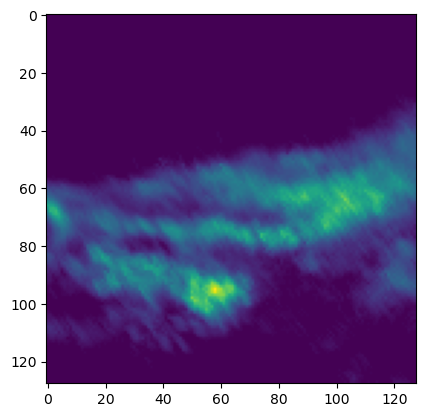

In [315]:
sample_block_vals = sample_block.RV_recalc.values
plt.figure()
plt.imshow(sample_block_vals, cmap='viridis')
# group by day xarray --> group by day to split in training and validation

In [312]:
valid_coords.shape

(1459, 3)

In [313]:
# TODO: The filter condition does not work yet!! 
for i in range(valid_coords.shape[0]):
# i = 1
    coord = valid_coords[i, :]
    block = folded.isel(time_outer = coord[0],
                           y_outer = coord[1],
                           x_outer = coord[2])
    block = block.squeeze()
    block_vals = block.RV_recalc.values
    
    pixel_over_thres_ratio = (block_vals > threshold).sum() / len(sample_block_vals)
    if pixel_over_thres_ratio < threshold_percentage_pixels:
        print(f'Ratio is {pixel_over_thres_ratio} which is below {threshold_percentage_pixels}')